In [3]:
import time
import numpy as np
import h5py

import math
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

import nn
from optim import SGDOptimizer
from supervised_learning import MyMLPClassifier
from dataset.load_data import prepare_data_loader, load_catvnoncat_data

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # đặt kích thước mặc định của biểu đồ
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_catvnoncat_data()

y = 0. It's a non-cat picture.


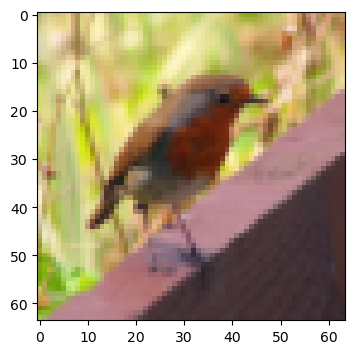

In [5]:
# Hình ảnh ví dụ
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[index]) + ". It's a " + classes[train_y[index]].decode("utf-8") +  " picture.")

In [6]:
# Khám phá tập dữ liệu
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (209,)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (50,)


In [7]:
def prepare_catvnoncat_data():
    train_x_orig, train_y, test_x_orig, test_y, classes = load_catvnoncat_data()
    # Định hình lại các ví dụ huấn luyện và kiểm tra
    train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)   # "-1" làm cho định hình lại làm phẳng các dimension còn lại
    test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

    # Chuẩn tắc hóa dữ liệu để có các giá trị nằm trong khoảng 0 và 1.
    train_x = train_x_flatten/255.
    test_x = test_x_flatten/255.

    print ("train_x's shape: " + str(train_x.shape))
    print ("test_x's shape: " + str(test_x.shape))
    print ("train_y's shape: " + str(train_y.shape))
    print ("test_y's shape: " + str(test_y.shape))
    print()

    return train_x, test_x, train_y, test_y


def prepare_trainer(model):
    optimizer = SGDOptimizer(model, learning_rate=0.0075, regularization=0.015, decay_learning_rate=False)
    loss_func = nn.BCELoss()
    return optimizer, loss_func


def build_model(n_in, n_class):
    np.random.seed(101)
    model = MyMLPClassifier(n_input=n_in, hiddens=[20, 7, 5], n_output=1, activation='relu')   
    return model

In [10]:
def main():
    X_tr, X_te, y_tr, y_te = prepare_catvnoncat_data()
    n_in, n_class = X_tr.shape[1], 2

    num_epochs = 580
    batch_size = 8

    model = build_model(n_in, n_class)
    optimizer, loss_func = prepare_trainer(model)

    model.info()

    # Training loop
    for epoch in range(num_epochs):
        # Prepare the data loader for training data
        data_loader = prepare_data_loader(X_tr, y_tr, batch_size)
        
        # Initialize counters for tracking training progress
        step = 0
        total_loss, total_correct = 0, 0
        total_sample = 0

        for batch_X, batch_y in data_loader:
            # forward pass: compute logits and loss                     
            batch_logit = model.forward(batch_X)    # output model: logit 
            loss = loss_func.forward(batch_logit, batch_y)

            # backward pass and an optimization step
            optimizer.zero_grad()
            dout = loss_func.backward()
            model.backward(dout)
            optimizer.step()

            # log training progress
            step += 1
            total_loss += loss
            probability = loss_func.probability     # logit --> probability
            batch_yp = (probability >= 0.5).astype(int).flatten()
            total_correct += np.sum(batch_yp == batch_y)
            total_sample += len(batch_y)
        print(f"Epoch: {epoch}, loss={total_loss / total_sample:.4f}, train_acc={total_correct / total_sample:.4f}")

    model.eval()

    logits_test = model.forward(X_te)
    probability = nn.Sigmoid().forward(logits_test)
    ypred = (probability >= 0.5).astype(int)
    print("\n My model: Classification report of test set:\n", classification_report(y_te, ypred))

    
    skmodel = MLPClassifier()
    skmodel.fit(X_tr, y_tr)

     # Print information about the trained scikit-learn MLPClassifier
    print("\nScikit-learn MLPClassifier Info:")
    print("Number of layers:", skmodel.n_layers_)
    print("Number of neurons in each layer:", skmodel.hidden_layer_sizes)
    print("Number of output classes:", skmodel.n_outputs_)
    print("Activation function:", skmodel.activation)
    print("Solver:", skmodel.solver)
    print("Learning rate:", skmodel.learning_rate)
    print("Initial learning rate:", skmodel.learning_rate_init)
    print("Batch size:", skmodel.batch_size)
    print("Maximum number of iterations:", skmodel.max_iter)
    # Add more model-specific information as needed

    ypred = skmodel.predict(X_te)
    print("\n Sklearn model: Classification report of test set:\n", classification_report(y_te, ypred))

In [11]:
if __name__ == "__main__":
    main()

train_x's shape: (209, 12288)
test_x's shape: (50, 12288)
train_y's shape: (209,)
test_y's shape: (50,)

MyMLPClassifier(
(linear): Linear(in_features=12288, out_features=20, bias=True)
(relu): ReLU()
(linear): Linear(in_features=20, out_features=7, bias=True)
(relu): ReLU()
(linear): Linear(in_features=7, out_features=5, bias=True)
(relu): ReLU()
(linear): Linear(in_features=5, out_features=1, bias=True)
)
Epoch: 0, loss=0.0874, train_acc=0.6364
Epoch: 1, loss=0.0839, train_acc=0.6555
Epoch: 2, loss=0.0838, train_acc=0.6555
Epoch: 3, loss=0.0828, train_acc=0.6555
Epoch: 4, loss=0.0820, train_acc=0.6555
Epoch: 5, loss=0.0810, train_acc=0.6555
Epoch: 6, loss=0.0805, train_acc=0.6555
Epoch: 7, loss=0.0795, train_acc=0.6555
Epoch: 8, loss=0.0786, train_acc=0.6555
Epoch: 9, loss=0.0777, train_acc=0.6555
Epoch: 10, loss=0.0768, train_acc=0.6555
Epoch: 11, loss=0.0758, train_acc=0.6555
Epoch: 12, loss=0.0749, train_acc=0.6651
Epoch: 13, loss=0.0738, train_acc=0.6603
Epoch: 14, loss=0.0730, t